In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_13421/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [34]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC

In [3]:
df = pd.read_csv('data/all_questions_data.csv')

In [4]:
df.head()

,Question Title,Question Slug,Question ID,Question Text,Topic Tagged text,Topic Tagged ID,Difficulty Level,Success Rate,total submission,total accepted,company tag,Likes,Dislikes,Hints,Similar Questions ID,Similar Questions Text
0,Minimum Interval to Include Each Query,minimum-interval-to-include-each-query,1977,"You are given a 2D integer array intervals, wh...","Array,Binary Search,Line Sweep,Sorting,Heap (P...","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjEx,VG9w...",Hard,45.5,14492,6599,NaN,336,6,Is there a way to order the intervals and quer...,NaN,NaN
1,Distinct Numbers in Each Subarray,distinct-numbers-in-each-subarray,2003,NaN,"Array,Hash Table,Sliding Window","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjY=,VG9w...",Medium,72.6,5116,3712,NaN,73,3,Keep a frequency map of the elements in each w...,NaN,NaN
2,Convert Date Format,convert-date-format,2004,NaN,Database,VG9waWNUYWdOb2RlOjYxMDQz,Easy,87.8,7506,6589,NaN,28,31,NaN,NaN,NaN
3,Maximum Population Year,maximum-population-year,1983,You are given a 2D integer array logs where ea...,"Array,Counting","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjYxMDYy",Easy,58.6,49364,28951,NaN,539,77,For each year find the number of people whose ...,NaN,NaN
4,Maximum Distance Between a Pair of Values,maximum-distance-between-a-pair-of-values,1984,You are given two non-increasing 0-indexed int...,"Array,Two Pointers,Binary Search,Greedy","VG9waWNUYWdOb2RlOjU=,VG9waWNUYWdOb2RlOjk=,VG9w...",Medium,50.0,43219,21602,NaN,564,11,Since both arrays are sorted in a non-increasi...,2199,Two Furthest Houses With Different Colors


In [5]:
# Remove null values

df = df[['Question Title','Question Text', 'Topic Tagged text']].dropna()

In [6]:
# Combine Text and description
df['text_all'] = df.apply(lambda x: x['Question Title'] + x['Question Text'], axis=1)

In [7]:
# Text cleaning

def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
     # remove whitespaces 
    text = ' '.join(text.split())
    # convert text to lowercase 
    text = text.lower() 
    
    return text

df['text_new'] = df['text_all'].apply(lambda x: clean_text(x))

In [9]:
df[['text_all','text_new']].head()

,text_all,text_new
0,Minimum Interval to Include Each QueryYou are ...,minimum interval to include each queryyou are ...
3,Maximum Population YearYou are given a 2D inte...,maximum population yearyou are given a d integ...
4,Maximum Distance Between a Pair of ValuesYou a...,maximum distance between a pair of valuesyou a...
5,Maximum Subarray Min-ProductThe min-product of...,maximum subarray min productthe min product of...
6,Largest Color Value in a Directed GraphThere i...,largest color value in a directed graphthere i...


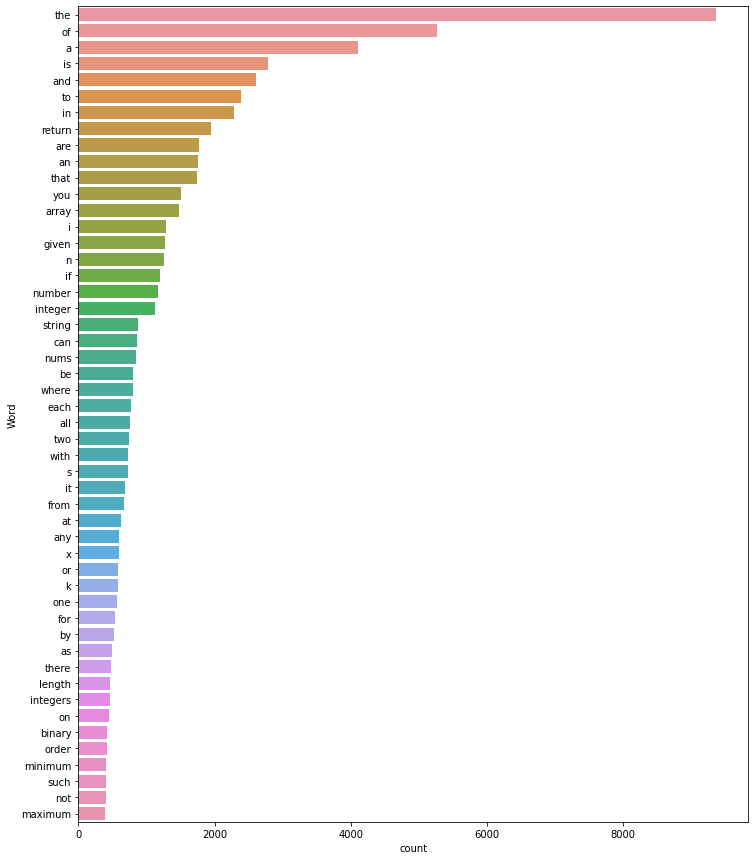

In [12]:
# Find most frequent words

def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

# Top 50
freq_words(df['text_new'], 50)

In [13]:
# Remove stopwords

nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return " ".join(no_stopword_text)

df['text_new'] = df['text_new'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manthan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


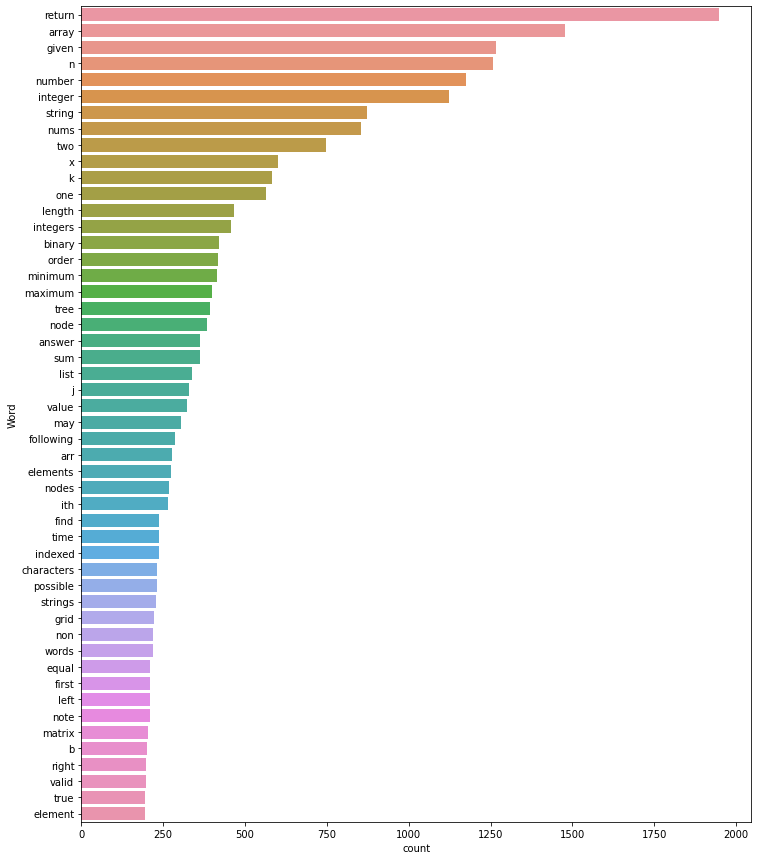

In [14]:
freq_words(df['text_new'], 50)

In [15]:
# Transform Label (topics) from str to list

df['topics_new'] = df['Topic Tagged text'].apply(lambda x: x.split(','))

In [16]:
df['topics_new']

0       [Array, Binary Search, Line Sweep, Sorting, He...
3                                       [Array, Counting]
4            [Array, Two Pointers, Binary Search, Greedy]
5             [Array, Stack, Monotonic Stack, Prefix Sum]
6       [Hash Table, Dynamic Programming, Graph, Topol...
                              ...                        
2233                 [Array, Hash Table, Greedy, Sorting]
2234    [Dynamic Programming, Bit Manipulation, Breadt...
2235                                      [Array, String]
2236                                              [Array]
2237       [Array, Segment Tree, Line Sweep, Ordered Set]
Name: topics_new, Length: 1758, dtype: object

In [17]:
# converting text List to features

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['topics_new'])

# transform target variables
y = multilabel_binarizer.transform(df['topics_new'])

In [18]:
len(y[0])

71

In [19]:
# Feature Extractions
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)

In [20]:
# Split out train, val set
xtrain, xval, ytrain, yval = train_test_split(df['text_new'], y, test_size=0.2, random_state=42)

In [21]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [24]:
# start building prediction model

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [25]:
# Fir model
clf.fit(xtrain_tfidf, ytrain)

/home/manthan/sportsseam/pyenv/ml/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression())

In [26]:
# predict
y_pred = clf.predict(xval_tfidf)

In [27]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Math', 'String')

In [28]:
# Evaluate performance
f1_score(yval, y_pred, average="micro")

0.4698275862068966

In [29]:
# Set a threshold

y_pred_prob = clf.predict_proba(xval_tfidf)

In [30]:
t = 0.3 # new value
y_pred_new = (y_pred_prob >= t).astype(int)

In [31]:
# new F1
f1_score(yval, y_pred_new, average="micro")

0.5626134301270418

### Inference

In [32]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [33]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Que: ", df['text_new'][k], "\nPredicted Topics: ", infer_tags(xval[k])), print("Actual Topics: ",df['topics_new'][k], "\n")

Que:  number wonderful substringsa wonderful string string one letter appears odd number times given string word consists first ten lowercase english letters j return number wonderful non empty substrings word substring appears multiple times word count occurrence separately substring contiguous sequence characters string 
Predicted Topics:  [('String',)]
Actual Topics:  ['Hash Table', 'String', 'Bit Manipulation', 'Prefix Sum'] 

Que:  palindrome partitioning iigiven string partition every substring partition palindrome return minimum cuts needed palindrome partitioning 
Predicted Topics:  [('String',)]
Actual Topics:  ['String', 'Dynamic Programming'] 

Que:  largest component size common factoryou given integer array unique positive integers nums consider following graph return size largest connected component graph 
Predicted Topics:  [('Array',)]
Actual Topics:  ['Array', 'Math', 'Union Find'] 

Que:  minimize deviation arrayyou given array nums n positive integers perform two typ

#### SVM Model

In [35]:
svm = LinearSVC(random_state=42)

In [36]:
clf_svm = OneVsRestClassifier(svm)

In [37]:
# fit
clf_svm = clf_svm.fit(xtrain_tfidf, ytrain)

/home/manthan/sportsseam/pyenv/ml/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(


In [38]:
y_pred = clf_svm.predict(xval_tfidf)

In [39]:
# Evaluate performance
f1_score(yval, y_pred, average="micro")

0.5912408759124087